In [18]:
import json
import nltk
import re
import csv
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd

pd.set_option('display.max_colwidth', 300)

# Read data
movie = pd.read_csv('Data/MovieSummaries/movie.metadata.tsv', delimiter='\t', header=None)
movie.columns = ["movie_id", 1, "movie_name", 3, 4, 5 ,6, 7, "genre"]
plot = pd.read_csv('Data/MovieSummaries/plot_summaries.txt', delimiter='\t', header=None)
plot.columns = ["movie_id", "plot"]

data = movie[["movie_id", "movie_name", "genre"]].merge(plot, on="movie_id")

# Extract genres
genre = []
for i in data["genre"]:
    genre.append(list(json.loads(i).values()))
data["genre_new"] = genre
data_new = data[~(data["genre_new"].str.len() == 0)]

# Preprocessing functions
def clean_text(text):
    text = re.sub("\'", "", text)
    text = re.sub("[^a-zA-Z]", " ", text)
    text = " ".join(text.split())
    text = text.lower()
    return text

def remove_stopwords(text):
    no_stop = []
    for i in text.split():
        if i not in stopwords:
            no_stop.append(i)
    return " ".join(no_stop)

def freq_plot(text):
    
    words = " ".join([x for x in text])
    words = words.split()
    fdist = nltk.FreqDist(words)
    return fdist


data_new["clean_plot"] = data_new["plot"].apply(lambda x : clean_text(x))

# Get stopwords
from nltk.corpus import stopwords
stopwords = set(stopwords.words("english"))
data_new["clean_plot"] = data_new["clean_plot"].apply(lambda x : remove_stopwords(x))

# Binarize genres
from sklearn.preprocessing import MultiLabelBinarizer
multilabel_bina = MultiLabelBinarizer()
multilabel_bina.fit(data_new["genre_new"])
y = multilabel_bina.transform(data_new["genre_new"])

# TF-IDF Vectorizer
tfidf_vect = TfidfVectorizer(max_df= 0.8, max_features=10000)
xtrain, xval, ytrain, yval = train_test_split(data_new["clean_plot"], y, test_size = 0.2, random_state= 9)
xtrain_tfidf = tfidf_vect.fit_transform(xtrain)
xval_tfidf = tfidf_vect.transform(xval)




C:\Users\Gabriel\AppData\Local\Temp\ipykernel_19600\1140240088.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_new["clean_plot"] = data_new["plot"].apply(lambda x : clean_text(x))
C:\Users\Gabriel\AppData\Local\Temp\ipykernel_19600\1140240088.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_new["clean_plot"] = data_new["clean_plot"].apply(lambda x : remove_stopwords(x))


## Clean Text process

+ Remove Apostrophes:

    This line uses regular expressions (re.sub) to replace apostrophes with nothing, effectively removing them from the text.

+ Retain Only Alphabets:

    Using regular expressions, this line replaces any character that is not an alphabet (both lowercase and uppercase) with a space.

+ Remove Extra Whitespace:

+ Convert to Lowercase

# Plot Genres

<Axes: xlabel='Count', ylabel='Genre'>

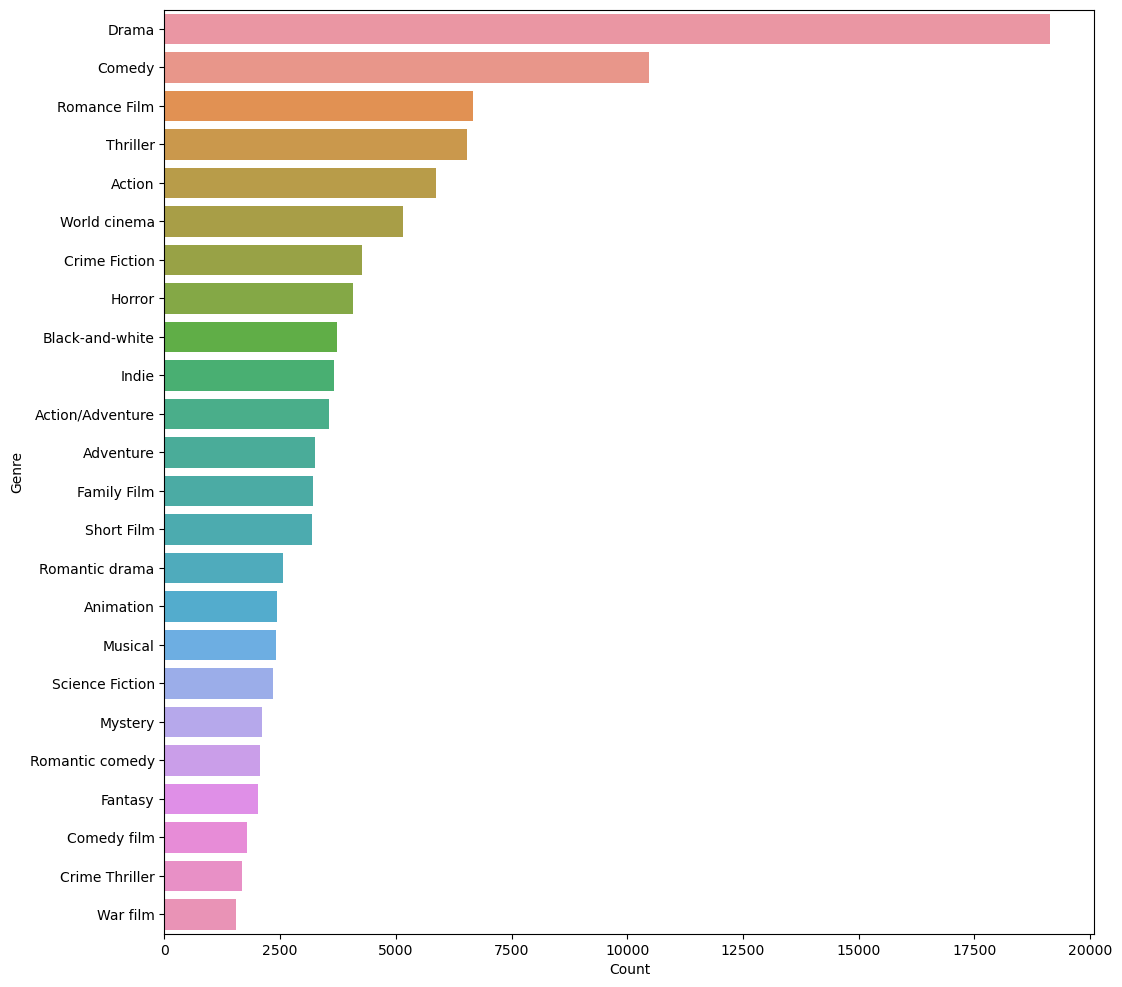

In [17]:

genre = []

for i in data["genre"]:
    #print(list(json.loads(i).values()))
    genre.append(list(json.loads(i).values()))

data["genre_new"] = genre

data_new = data[~(data["genre_new"].str.len() == 0)]

dumm = []

for i in genre:
    for j in i:
        #print(j)
        dumm.append(j)
all_genre = list(set(dumm))


genre_new = nltk.FreqDist(dumm)
genre_df = pd.DataFrame.from_dict(genre_new, orient="index")
genre_df.columns = ["Count"]
genre_df = genre_df.reset_index()
genre_df.columns = ["Genre", "Count"]


plt.figure(figsize=(12,12))
sns.barplot(data=genre_df.sort_values("Count", ascending=False).loc[:20, :], x="Count", y="Genre")

# Plot Stopwords

C:\Users\Gabriel\AppData\Local\Temp\ipykernel_19600\1687550783.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_new["clean_plot"] = data_new["plot"].apply(lambda x : clean_text(x))


<Axes: xlabel='Count', ylabel='Word'>

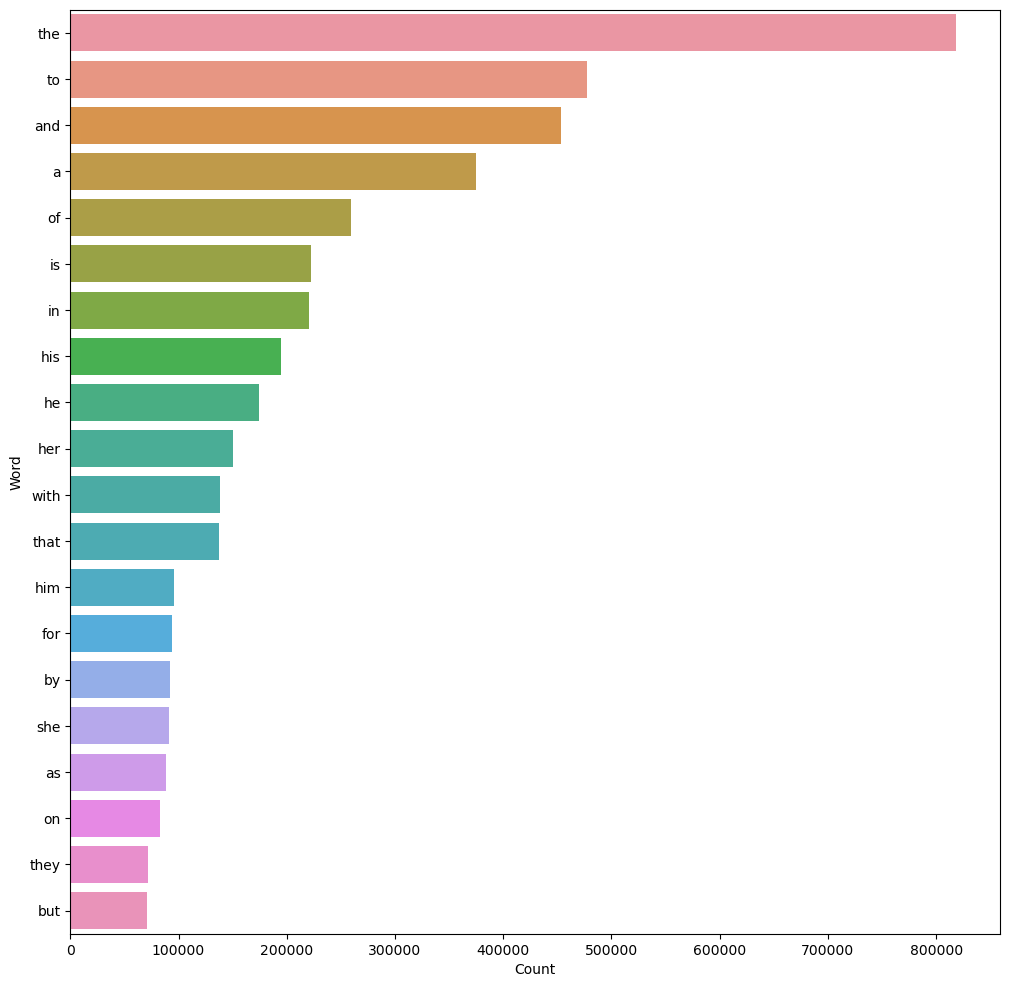

In [20]:
data_new["clean_plot"] = data_new["plot"].apply(lambda x : clean_text(x))

fdist = freq_plot(data_new["clean_plot"])
words_df = pd.DataFrame.from_dict(fdist, orient="index")
words_df = words_df.reset_index()
words_df.columns = ["Word","Count"]


plt.figure(figsize=(12,12))
sns.barplot(data= words_df.sort_values(by="Count",ascending= False).iloc[:20, :], x = "Count", y= "Word")

# Random Forest classification

In [10]:
# Use Random Forest for classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report

rf_classifier = RandomForestClassifier()
onevsall_rf = OneVsRestClassifier(rf_classifier)
onevsall_rf.fit(xtrain_tfidf, ytrain)

# Predict and evaluate
y_pred = onevsall_rf.predict(xval_tfidf)
print(classification_report(yval, y_pred))

# Predict function
def new_val_rf(x):  
    x = clean_text(x)
    x = remove_stopwords(x)
    x_vec = tfidf_vect.transform([x])
    x_pred = onevsall_rf.predict(x_vec)
    return multilabel_bina.inverse_transform(x_pred)




c:\Users\Gabriel\anaconda3\Lib\site-packages\sklearn\multiclass.py:84: UserWarning: Label not 202 is present in all training examples.
  warnings.warn(
c:\Users\Gabriel\anaconda3\Lib\site-packages\sklearn\multiclass.py:84: UserWarning: Label not 241 is present in all training examples.
  warnings.warn(
c:\Users\Gabriel\anaconda3\Lib\site-packages\sklearn\multiclass.py:84: UserWarning: Label not 245 is present in all training examples.
  warnings.warn(
c:\Users\Gabriel\anaconda3\Lib\site-packages\sklearn\multiclass.py:84: UserWarning: Label not 361 is present in all training examples.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        15
           1       0.00      0.00      0.00         2
           2       0.72      0.04      0.08      1237
           3       0.00      0.00      0.00        31
           4       0.00      0.00      0.00        78
           5       0.75      0.00      0.01       704
           6       0.00      0.00      0.00         8
           7       0.00      0.00      0.00        28
           8       0.00      0.00      0.00       681
           9       0.00      0.00      0.00        25
          10       0.00      0.00      0.00        14
          11       0.00      0.00      0.00         5
          12       0.00      0.00      0.00        19
          13       0.00      0.00      0.00         0
          14       0.00      0.00      0.00        17
          15       0.00      0.00      0.00        24
          16       0.00      0.00      0.00         2
          17       0.00    

c:\Users\Gabriel\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Gabriel\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Gabriel\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [11]:
#save model
import pickle
#pickle.dump(onevsall_rf, open('model.pkl','wb'))


In [14]:
# Sample predictions
for i in range(5): 
  k = xval.sample(1).index[0] 
  print("Movie: ", data_new['movie_name'][k], "\nPredicted genre: ", new_val_rf(xval[k]))
  print("Actual genre: ",data_new['genre_new'][k], "\n")

Movie:  A Simple Wish 
Predicted genre:  [()]
Actual genre:  ["Children's/Family", 'Fantasy', 'Comedy', 'Family Film', 'Fantasy Comedy', "Children's Fantasy"] 

Movie:  Based Down South 
Predicted genre:  [('Drama',)]
Actual genre:  ['Documentary'] 

Movie:  Are You Ready for Love? 
Predicted genre:  [()]
Actual genre:  ['Romantic comedy', 'Comedy'] 

Movie:  Swing Hostess 
Predicted genre:  [()]
Actual genre:  ['Music', 'Musical', 'Drama', 'Romance Film', 'Comedy film'] 

Movie:  The Past-Master 
Predicted genre:  [('Drama',)]
Actual genre:  ['Comedy film', 'Family Film'] 



# Multi label logistic Regression

In [5]:

# Train model
logistic_mod = LogisticRegression()
onevsall = OneVsRestClassifier(logistic_mod)
onevsall.fit(xtrain_tfidf, ytrain)

# Predict and evaluate
y_pred = onevsall.predict(xval_tfidf)
print(classification_report(yval, y_pred))

# Sample predictions
def new_val(x):  
    x = remove_stopwords(clean_text(x))
    x_vec = tfidf_vect.transform([x])
    x_pred = onevsall.predict(x_vec)
    return multilabel_bina.inverse_transform(x_pred)



c:\Users\Gabriel\anaconda3\Lib\site-packages\sklearn\multiclass.py:84: UserWarning: Label not 202 is present in all training examples.
  warnings.warn(
c:\Users\Gabriel\anaconda3\Lib\site-packages\sklearn\multiclass.py:84: UserWarning: Label not 241 is present in all training examples.
  warnings.warn(
c:\Users\Gabriel\anaconda3\Lib\site-packages\sklearn\multiclass.py:84: UserWarning: Label not 245 is present in all training examples.
  warnings.warn(
c:\Users\Gabriel\anaconda3\Lib\site-packages\sklearn\multiclass.py:84: UserWarning: Label not 361 is present in all training examples.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        15
           1       0.00      0.00      0.00         2
           2       0.66      0.25      0.36      1237
           3       0.00      0.00      0.00        31
           4       0.00      0.00      0.00        78
           5       0.51      0.09      0.16       704
           6       0.00      0.00      0.00         8
           7       0.00      0.00      0.00        28
           8       0.71      0.12      0.21       681
           9       0.00      0.00      0.00        25
          10       0.00      0.00      0.00        14
          11       0.00      0.00      0.00         5
          12       0.00      0.00      0.00        19
          13       0.00      0.00      0.00         0
          14       0.00      0.00      0.00        17
          15       0.00      0.00      0.00        24
          16       0.00      0.00      0.00         2
          17       0.00    

c:\Users\Gabriel\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Gabriel\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Gabriel\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [9]:
for i in range(5): 
    k = xval.sample(1).index[0] 
    print("Movie: ", data_new['movie_name'][k], "\nPredicted genre: ", new_val(xval[k]))
    print("Actual genre: ",data_new['genre_new'][k], "\n")

Movie:  Painting the Clouds with Sunshine 
Predicted genre:  [('Comedy', 'Romance Film')]
Actual genre:  ['Musical'] 

Movie:  The Scarlet Pimpernel 
Predicted genre:  [('Drama',)]
Actual genre:  ['Swashbuckler films', 'Adventure', 'Costume drama', 'Black-and-white', 'Action/Adventure', 'Drama', 'Comedy', 'Film adaptation', 'Action'] 

Movie:  Tar Creek 
Predicted genre:  [()]
Actual genre:  ['Drama', 'Documentary'] 

Movie:  A Bird In A Guilty Cage 
Predicted genre:  [('Animation', 'Family Film', 'Short Film')]
Actual genre:  ['Short Film', 'Family Film', 'Comedy film', 'Animation'] 

Movie:  Crank: High Voltage 
Predicted genre:  [()]
Actual genre:  ['Thriller', 'Crime Fiction', 'Action', 'Comedy'] 

